# Machine Learning estimation for std properties

Based on the Molar Mass, State of Matter, and Charge, we now create machine learning models to predict the standard free Gibbs energy of formation, enthalpy, entropy, and heat capacities.

## Required dependencies

In [88]:
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder

from pathlib import Path
import os

DATA_PATH = Path(os.environ.get("DATAPATH"))
sklearn.set_config(transform_output="pandas")

## Read preprocessed data

In [89]:
df_nist_stdprops = pd.read_csv(DATA_PATH / "NBS_Tables_preprocessed.csv", index_col=0)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0


## Organizing the data

Separating features and targets:

In [90]:
features_columns = ["Molar Mass", "State", "Charge"]
target_columns = ["deltaH0", "deltaG0", "S0", "Cp"]

X = df_nist_stdprops[features_columns]
y = df_nist_stdprops[target_columns]

### Encoding the State of Matter feature

Let's put together state of matter with few occurences (unsure if this is a good approach):

In [91]:
X["State"].value_counts()

State
cr     711
g      531
ai      99
l       75
ao      39
cr2     27
g2      14
cr3      8
l2       7
am       4
g3       2
cr4      2
l3       1
Name: count, dtype: int64

In [92]:
state_renamings = {
    "g2": "g",
    "cr3": "cr",
    "l2": "l",
    "g3": "g",
    "cr4": "cr",
    "l3": "l",
}
# X.replace(state_renamings, inplace=True)

In [93]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X[["State"]])

encoder_categories = list(encoder.categories_[0])

encoder_categories

['ai', 'am', 'ao', 'cr', 'cr2', 'cr3', 'cr4', 'g', 'g2', 'g3', 'l', 'l2', 'l3']

In [94]:
X_state_encoded = encoder.transform(X[["State"]])

X_state_encoded

,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1516,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1517,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1518,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
X_encoded = pd.concat([X, X_state_encoded], axis=1)
X_encoded.drop(columns=["State"], inplace=True)

X_encoded

,Molar Mass,Charge,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
0,15.9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,31.9988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,47.9982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0080,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,175.7152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1516,568.1949,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1517,302.8044,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1518,481.7986,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Splitting the data:

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=0.2)

In [97]:
X_train

,Molar Mass,Charge,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
1423,174.2656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,203.3104,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1435,180.0372,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,62.0049,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1295,54.9886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,145.1493,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,38.9892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
860,107.9034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1459,486.0120,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
y_train

,deltaH0,deltaG0,S0,Cp
1423,-1437.79,-1321.37,175.56,131.46
1083,-2499.02,-2114.64,366.10,315.06
1435,-1180.70,-1035.90,155.02,126.73
111,-207.36,-111.25,146.40,-86.60
1295,-260.20,-218.40,115.90,72.13
...,...,...,...,...
1130,-1574.65,-1435.78,134.30,124.22
1294,105.00,82.40,228.60,34.70
860,-138.00,-163.00,231.82,33.14
1459,-1229.30,-1078.50,333.90,205.60


## Data scaling

In [99]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)  
X_test_rescaled = scaler.transform(X_test)  

In [100]:
X_train_rescaled

,Molar Mass,Charge,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
1423,0.012310,-0.067642,-0.274144,-0.057448,-0.150692,1.064581,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
1083,0.204875,-0.067642,-0.274144,-0.057448,-0.150692,1.064581,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
1435,0.050575,-0.067642,-0.274144,-0.057448,-0.150692,1.064581,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
111,-0.731971,-3.494858,-0.274144,-0.057448,6.636041,-0.939336,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
1295,-0.778489,-0.067642,-0.274144,-0.057448,-0.150692,1.064581,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.180729,-0.067642,-0.274144,-0.057448,-0.150692,-0.939336,7.202053,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
1294,-0.884564,-0.067642,-0.274144,-0.057448,-0.150692,-0.939336,-0.138849,-0.081379,-0.028689,1.389288,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
860,-0.427667,-0.067642,-0.274144,-0.057448,-0.150692,-0.939336,-0.138849,-0.081379,-0.028689,1.389288,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689
1459,2.079169,-0.067642,-0.274144,-0.057448,-0.150692,1.064581,-0.138849,-0.081379,-0.028689,-0.719793,-0.099834,-0.028689,-0.23764,-0.057448,-0.028689


## Build the machine learning model (Neural Network, in this case)

Initialize the Multilayer Percepton with ADAM:

In [101]:
regr = MLPRegressor(	
    solver='adam',
    learning_rate='adaptive',
    hidden_layer_sizes=(10, 30, 20, 10),  # 10:30:20:10 architecture
    random_state=1, 
    max_iter=10000,  # 10k epochs
    tol=1e-5,
    n_iter_no_change=1000,
    early_stopping=True
)

Run training:

In [102]:
regr.fit(X_train_rescaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 30, 20, 10),
             learning_rate='adaptive', max_iter=10000, n_iter_no_change=1000,
             random_state=1, tol=1e-05)

Run predictions:

In [103]:
y_predict = regr.predict(X_test_rescaled)

In [104]:
dict_y_predict = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict[target] = y_predict[:, id_target]
    
df_y_predict = pd.DataFrame.from_dict(dict_y_predict)

df_y_predict

,deltaH0,deltaG0,S0,Cp
0,-377.649987,-377.751015,50.420810,35.110703
1,-64.747449,-64.537790,8.080045,6.086342
2,-948.770062,-951.241389,126.110400,88.518844
3,-1906.828535,-1911.455538,254.898759,176.810653
4,-1906.423408,-1911.049519,254.844298,176.773322
...,...,...,...,...
299,-62.718488,-62.499466,7.809859,5.893052
300,-68.388757,-68.195901,8.564938,6.433232
301,-1096.764015,-1099.606816,146.001502,102.164996
302,-62.005382,-61.782825,7.714922,5.825003


Check the score (not informative though):

In [105]:
regr.score(X_test_rescaled, y_test)

-0.2120951725391431

## Assess the results

In [106]:
import matplotlib.pyplot as plt

Check `deltaH0` results:

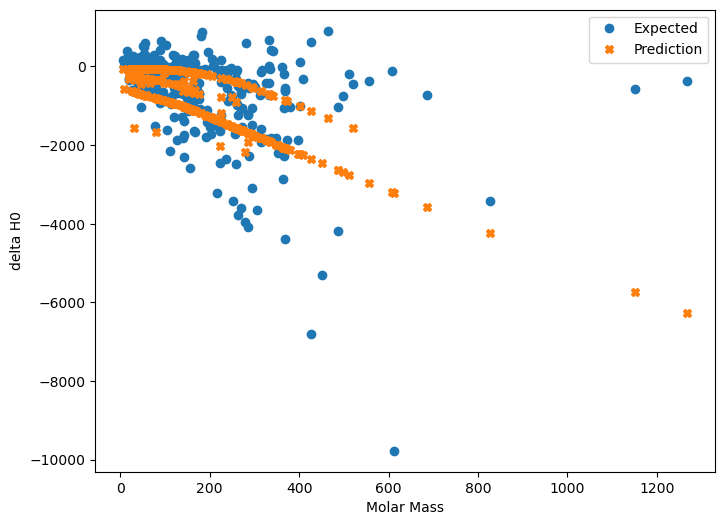

In [107]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["deltaH0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["deltaH0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("delta H0")

plt.legend()

plt.show()

Check `deltaG0` results:

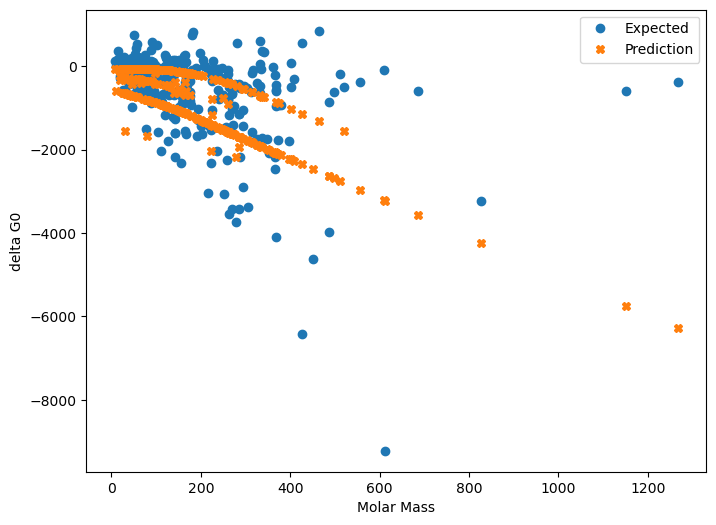

In [108]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["deltaG0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["deltaG0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("delta G0")

plt.legend()

plt.show()

Check `S0` results:

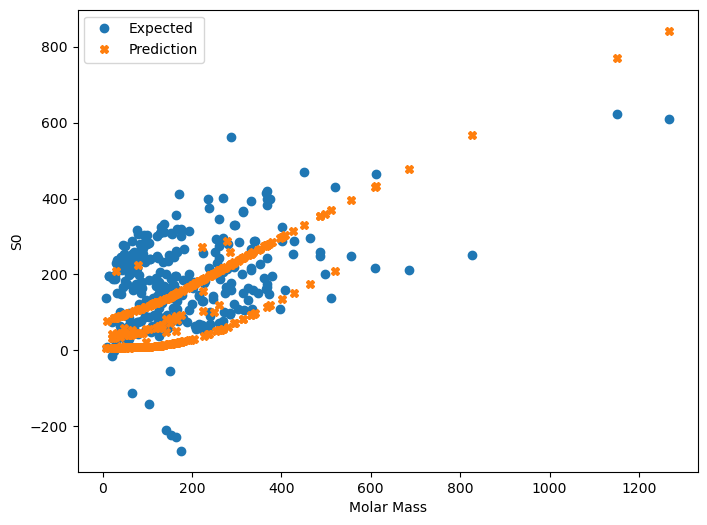

In [109]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["S0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["S0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("S0")

plt.legend()

plt.show()

Check `Cp` results:

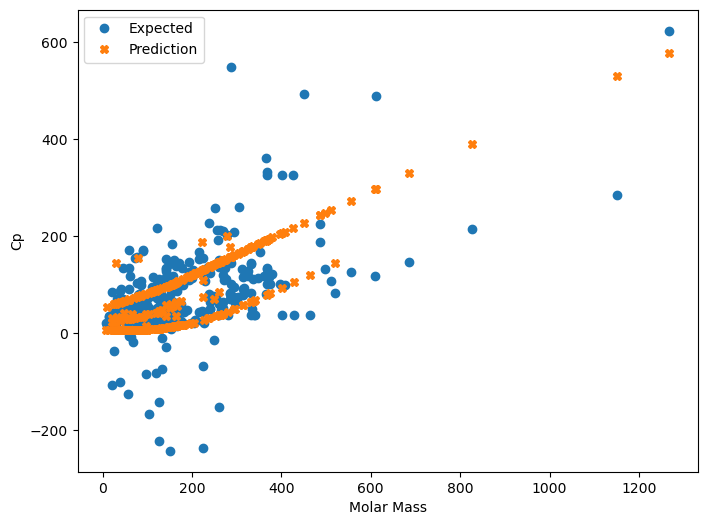

In [110]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["Cp"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["Cp"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("Cp")

plt.legend()

plt.show()